In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions files -c carvana-image-masking-challenge

name                              size  creationDate                
-------------------------  -----------  --------------------------  
29bb3ece3180_11.jpg             109920  2019-12-12 00:50:29.282000  
metadata.csv.zip                 83109  2019-12-12 00:50:29.409000  
sample_submission.csv.zip       206457  2019-12-12 00:50:29.323000  
test.zip                    8328838743  2019-12-12 00:56:58.191000  
test_hq.zip                16588751874  2019-12-12 01:08:26.498000  
train.zip                    424233528  2019-12-12 00:55:35.467000  
train_hq.zip                 843301716  2019-12-12 00:55:42.352000  
train_masks.csv.zip           16001807  2019-12-12 00:55:27.559000  
train_masks.zip               30537860  2019-12-12 00:55:27.378000  


In [ ]:
!kaggle competitions download -c carvana-image-masking-challenge -f train.zip

 81% 326M/405M [00:02<00:01, 79.0MB/s]
100% 405M/405M [00:02<00:00, 151MB/s] 


In [ ]:
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip


  0% 0.00/29.1M [00:00<?, ?B/s]
100% 29.1M/29.1M [00:00<00:00, 1.19GB/s]


In [ ]:
!ls -lh

total 434M
-rw-r--r-- 1 root root   71 Feb  5 08:39 kaggle.json
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
-rw-r--r-- 1 root root  30M Dec 12  2019 train_masks.zip
-rw-r--r-- 1 root root 405M Dec 12  2019 train.zip


In [ ]:
!unzip train.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/0789bed99cb8_09.jpg  
  inflating: train/0789bed99cb8_10.jpg  
  inflating: train/0789bed99cb8_11.jpg  
  inflating: train/0789bed99cb8_12.jpg  
  inflating: train/0789bed99cb8_13.jpg  
  inflating: train/0789bed99cb8_14.jpg  
  inflating: train/0789bed99cb8_15.jpg  
  inflating: train/0789bed99cb8_16.jpg  
  inflating: train/0795e132d090_01.jpg  
  inflating: train/0795e132d090_02.jpg  
  inflating: train/0795e132d090_03.jpg  
  inflating: train/0795e132d090_04.jpg  
  inflating: train/0795e132d090_05.jpg  
  inflating: train/0795e132d090_06.jpg  
  inflating: train/0795e132d090_07.jpg  
  inflating: train/0795e132d090_08.jpg  
  inflating: train/0795e132d090_09.jpg  
  inflating: train/0795e132d090_10.jpg  
  inflating: train/0795e132d090_11.jpg  
  inflating: train/0795e132d090_12.jpg  
  inflating: train/0795e132d090_13.jpg  
  inflating: train/0795e132d090_14.jpg  
  inflating: train/0795e132d090_15.jpg  
  infl

In [ ]:
!unzip train_masks.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_masks/0789bed99cb8_09_mask.gif  
 extracting: train_masks/0789bed99cb8_10_mask.gif  
 extracting: train_masks/0789bed99cb8_11_mask.gif  
 extracting: train_masks/0789bed99cb8_12_mask.gif  
  inflating: train_masks/0789bed99cb8_13_mask.gif  
  inflating: train_masks/0789bed99cb8_14_mask.gif  
  inflating: train_masks/0789bed99cb8_15_mask.gif  
  inflating: train_masks/0789bed99cb8_16_mask.gif  
 extracting: train_masks/0795e132d090_01_mask.gif  
 extracting: train_masks/0795e132d090_02_mask.gif  
 extracting: train_masks/0795e132d090_03_mask.gif  
 extracting: train_masks/0795e132d090_04_mask.gif  
 extracting: train_masks/0795e132d090_05_mask.gif  
 extracting: train_masks/0795e132d090_06_mask.gif  
 extracting: train_masks/0795e132d090_07_mask.gif  
 extracting: train_masks/0795e132d090_08_mask.gif  
 extracting: train_masks/0795e132d090_09_mask.gif  
 extracting: train_masks/0795e132d090_10_mask.gif  
 extracting: 

In [ ]:
import torch
import torch.nn as nn

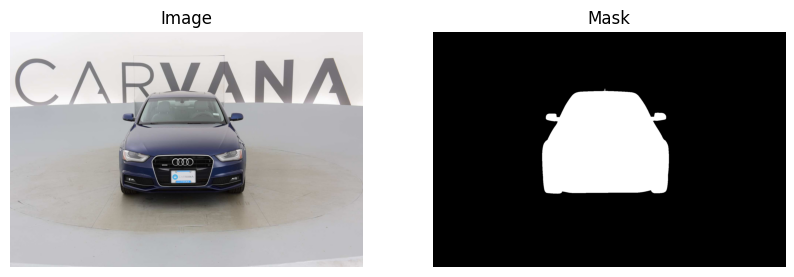

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('train/0cdf5b5d0ce1_01.jpg')
mask = cv2.imread('train_masks/0cdf5b5d0ce1_01_mask.gif', 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.show()


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [ ]:
class CarvanaDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_name = img_name.replace(".jpg", "_mask.gif")
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image / 255.0

        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask


In [ ]:
dataset = CarvanaDataset("train", "train_masks", img_size=256)

train_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.middle = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        m = self.middle(p3)

        u3 = self.up3(m)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return torch.sigmoid(self.out(u1))


In [ ]:
def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (
        pred.sum() + target.sum() + smooth
    )
    return 1 - dice


In [ ]:
bce = nn.BCELoss()

def total_loss(pred, target):
    return bce(pred, target) + dice_loss(pred, target)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = total_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.2102
Epoch [2/5], Loss: 0.0573
Epoch [3/5], Loss: 0.0373
Epoch [4/5], Loss: 0.0318
Epoch [5/5], Loss: 0.0261


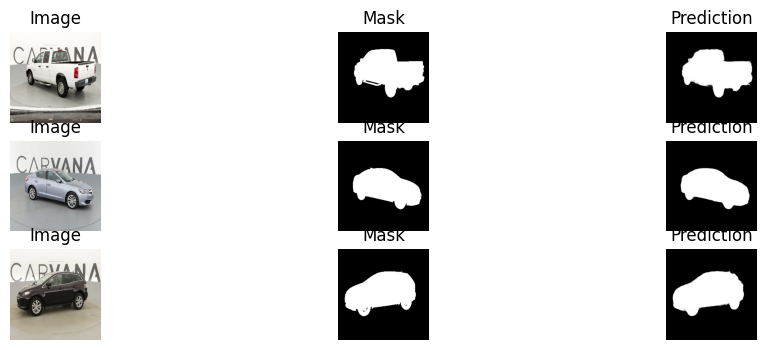

In [ ]:
model.eval()
images, masks = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    preds = model(images)

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(3,3,3*i+2)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(3,3,3*i+3)
    plt.imshow(preds[i][0].cpu(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

plt.show()


In [ ]:
model.eval()

images, masks = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    preds = model(images)

preds = (preds > 0.5).float()


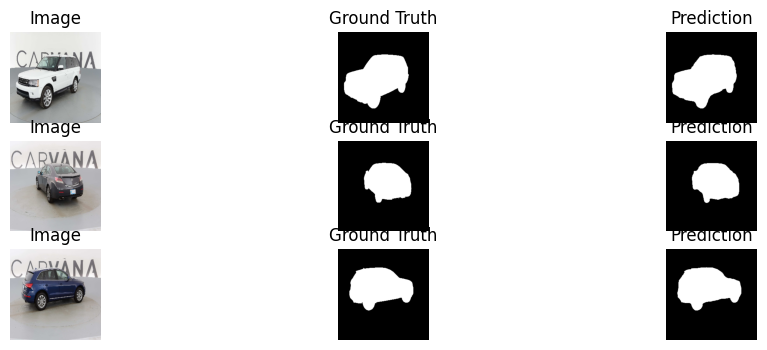

In [ ]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(3,3,3*i+2)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3,3,3*i+3)
    plt.imshow(preds[i][0].cpu(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

plt.show()


In [ ]:
def dice_score(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (
        pred.sum() + target.sum() + smooth
    )


In [ ]:
model.eval()
dice_total = 0

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds = (preds > 0.5).float()

        dice_total += dice_score(preds, masks).item()

print("Average Dice Score:", dice_total / len(train_loader))


Average Dice Score: 0.9906119121320592
